# Integrantes:  
Gaston Arida, Sebastian Ferreiro, Jeronimo Vernay

---

Nota: Los archivos originales fueron modificados para facilitar la lectura de los mismos. Aquí se encuentran
    en formato csv, y con pequeños cambios como nombres de columnas que no afectan a la información 
    concreta de los archivos originales.

---

# Leemos los archivos originales:

In [15]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

BP_limpio = pd.read_csv("TablasModelo\\BP_limpio.csv")                          
EE_limpio01 = pd.read_csv("TablasModelo\\EE_limpio_final_usando2daopcion.csv")
Provincia = pd.read_csv("TablasModelo\\Provincia.csv")
Depto = pd.read_csv("TablasModelo\\Departamento_corregido.csv")
Poblacion = pd.read_csv("TablasModelo\\Padron_limpio_final.csv")


duckdb.register("EE", EE_limpio01)
duckdb.register("Poblacion", Poblacion)
duckdb.register("Departamento", Depto)
duckdb.register("Provincia", Provincia)  
duckdb.register("BP", BP_limpio)

---

# Consultas SQL en base al modelo relacional:

# Primer consulta

In [ ]:
consulta1 = """
WITH ee_por_departamento AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT CASE WHEN Jardin > 0 THEN Cueanexo END) AS jardines,
        COUNT(DISTINCT CASE WHEN Primario > 0 THEN Cueanexo END) AS primarias,
        COUNT(DISTINCT CASE WHEN Secundario > 0 THEN Cueanexo END) AS secundarios
    FROM EE
    GROUP BY id_departamento
),
poblacion_por_departamento AS (
    SELECT 
        id_departamento,
        SUM(CASE WHEN "Rango etario" = '3 a 5' THEN casos ELSE 0 END) AS poblacion_jardin,
        SUM(CASE WHEN "Rango etario" = '6 a 11' THEN casos ELSE 0 END) AS poblacion_primaria,
        SUM(CASE WHEN "Rango etario" = '12 a 18' THEN casos ELSE 0 END) AS poblacion_secundaria
    FROM Poblacion
    GROUP BY id_departamento
)

SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,

    COALESCE(ee.jardines, 0) AS jardines,
    COALESCE(pob.poblacion_jardin, 0) AS poblacion_jardin,

    COALESCE(ee.primarias, 0) AS primarias,
    COALESCE(pob.poblacion_primaria, 0) AS poblacion_primaria,

    COALESCE(ee.secundarios, 0) AS secundarios,
    COALESCE(pob.poblacion_secundaria, 0) AS poblacion_secundaria

FROM Depto dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN ee_por_departamento ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_departamento pob ON dept.id_departamento = pob.id_departamento

ORDER BY prov.nombre ASC, primarias DESC;
"""

resultado = duckdb.query(consulta1).to_df()
print(f"resultados 1: {resultado}")

resultados 1:         provincia        departamento  jardines  poblacion_jardin  primarias  \
0    Buenos Aires          LA MATANZA       333           87162.0        335   
1    Buenos Aires            LA PLATA       234           29260.0        201   
2    Buenos Aires     LOMAS DE ZAMORA       170           28806.0        179   
3    Buenos Aires  GENERAL PUEYRREDON       178           23100.0        168   
4    Buenos Aires             QUILMES       160           26975.0        145   
..            ...                 ...       ...               ...        ...   
523       Tucumán             TRANCAS        25            1163.0         25   
524       Tucumán      TAFI DEL VALLE        22            1010.0         24   
525       Tucumán            FAMAILLA        24            2322.0         23   
526       Tucumán      JUAN B ALBERDI        20            1586.0         19   
527       Tucumán            LA COCHA        17             992.0         18   

     poblacion_primaria  

# Segunda consulta

In [ ]:
consulta2 = """
SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COUNT(*) AS Cant_BP_fundadas_desde_1950

FROM BP bp
JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
JOIN Provincia prov ON dept.id_provincia = prov.id

WHERE 
    TRY_CAST(SUBSTR(bp.fecha_fundacion, 1, 4) AS INTEGER) >= 1950

GROUP BY prov.nombre, dept.Departamento
ORDER BY prov.nombre ASC, Cant_BP_fundadas_desde_1950 DESC;
"""

resultado2 = duckdb.query(consulta2).to_df()
print(f"resultados 2: {resultado2}")

resultados 2:         provincia    departamento  Cant_BP_fundadas_desde_1950
0    Buenos Aires      LA MATANZA                           15
1    Buenos Aires        LA PLATA                           15
2    Buenos Aires          MORENO                           13
3    Buenos Aires    BAHIA BLANCA                           12
4    Buenos Aires           TIGRE                           12
..            ...             ...                          ...
357       Tucumán     YERBA BUENA                            1
358       Tucumán       RIO CHICO                            1
359       Tucumán  TAFI DEL VALLE                            1
360       Tucumán        FAMAILLA                            1
361       Tucumán      TAFI VIEJO                            1

[362 rows x 3 columns]


# Tercer consulta

In [ ]:
consulta3 = """
WITH bp_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT nro_conabip) AS cantidad_bp
    FROM BP
    GROUP BY id_departamento
),
ee_por_dpto AS (
    SELECT 
        id_departamento,
        COUNT(DISTINCT Cueanexo) AS cantidad_ee
    FROM EE
    GROUP BY id_departamento
),
poblacion_por_dpto AS (
    SELECT 
        id_departamento,
        SUM(casos) AS poblacion_total
    FROM Poblacion
    GROUP BY id_departamento
)

SELECT 
    prov.nombre AS provincia,
    dept.Departamento AS departamento,
    COALESCE(bp.cantidad_bp, 0) AS cantidad_bp,
    COALESCE(ee.cantidad_ee, 0) AS cantidad_ee,
    COALESCE(pob.poblacion_total, 0) AS poblacion_total

FROM Departamento dept
JOIN Provincia prov ON dept.id_provincia = prov.id
LEFT JOIN bp_por_dpto bp ON dept.id_departamento = bp.id_departamento
LEFT JOIN ee_por_dpto ee ON dept.id_departamento = ee.id_departamento
LEFT JOIN poblacion_por_dpto pob ON dept.id_departamento = pob.id_departamento

ORDER BY cantidad_ee DESC, cantidad_bp DESC, prov.nombre ASC, dept.Departamento ASC;
"""

resultado3 = duckdb.query(consulta3).to_df()
print(f"resultados 3: {resultado3}")

resultados 3:             provincia         departamento  cantidad_bp  cantidad_ee  \
0             Córdoba              CAPITAL           20         1418   
1            Santa Fe              ROSARIO           39         1277   
2        Buenos Aires           LA MATANZA           16         1201   
3        Buenos Aires             LA PLATA           33          859   
4               Chaco         SAN FERNANDO           31          805   
..                ...                  ...          ...          ...   
523          La Pampa        LIMAY MAHUIDA            0            5   
524          La Pampa         LIHUEL CALEL            1            4   
525          La Rioja            SANAGASTA            1            3   
526            Chubut             MARTIRES            0            3   
527  Tierra del Fuego  ANTARTIDA ARGENTINA            0            0   

     poblacion_total  
0          1498060.0  
1          1337958.0  
2          1837168.0  
3           756074.0  
4     

# Cuarta consulta

In [ ]:
consulta4 = """
SELECT provincia, departamento,
        /* Agaro solo el nombre principal del dominio (sin el .com)) */ 
       SPLIT_PART(dominio_mas_frecuente, '.', 1) AS dominio_principal
FROM (
  SELECT provincia, departamento, dominio AS dominio_mas_frecuente
  FROM (
    SELECT 
      prov.nombre AS provincia,
      dept.Departamento AS departamento,
      SPLIT_PART(bp.mail, '@', 2) AS dominio,   /* Agarro la parte después del @ */
      COUNT(*) AS count,    /* Cuenta repeticiones de cada dominio */
      ROW_NUMBER() OVER (
        PARTITION BY dept.id_departamento  /* Agrupo por departamento */
        ORDER BY COUNT(*) DESC  /* Ordeno dominios de mayor a menor */
      ) AS nro_fila /* la primer fila sera la mas frecuente */
    FROM BP bp
    JOIN Departamento dept ON bp.id_departamento = dept.id_departamento
    JOIN Provincia prov ON dept.id_provincia = prov.id
    WHERE bp.mail IS NOT NULL AND bp.mail LIKE '%@%'    /* Filtro mails válidos */
    GROUP BY prov.nombre, dept.Departamento, dept.id_departamento, dominio
  ) t
  WHERE nro_fila = 1
) final_result
ORDER BY provincia ASC, departamento ASC;
"""

resultado4 = duckdb.query(consulta4).to_df()
print(f"resultados 4: {resultado4}")

resultados 4:         provincia            departamento dominio_principal
0    Buenos Aires           ADOLFO ALSINA           hotmail
1    Buenos Aires  ADOLFO GONZALES CHAVES           hotmail
2    Buenos Aires                 ALBERTI           hotmail
3    Buenos Aires         ALMIRANTE BROWN             yahoo
4    Buenos Aires               ARRECIFES             yahoo
..            ...                     ...               ...
318       Tucumán                 CAPITAL           hotmail
319       Tucumán               CRUZ ALTA           hotmail
320       Tucumán                  LEALES             gmail
321       Tucumán                MONTEROS             yahoo
322       Tucumán             YERBA BUENA             yahoo

[323 rows x 3 columns]


---

# Gráficos:

# 1)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18556\3235440714.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico


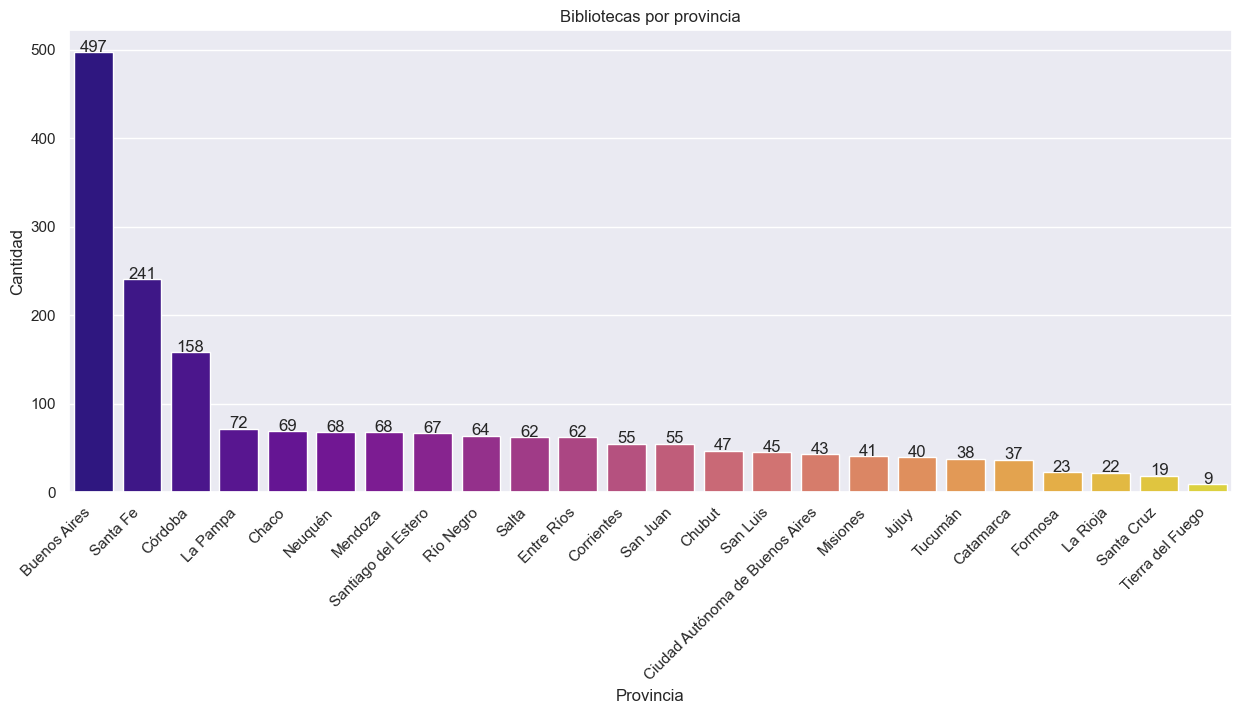

In [2]:
provincias = BP_limpio['provincia'].unique()

diccionario = {}
for provincia in provincias:
    diccionario[provincia] = len(BP_limpio.loc[BP_limpio['provincia'] == provincia])

# Creamos listas separadas para cada columna
provincias = list(diccionario.keys())
cantidad = list(diccionario.values())

# DataFrame con columnas
df = pd.DataFrame({
    'Provincia': provincias,
    'Cantidad': cantidad
})

df = df.sort_values(by='Cantidad', ascending=False) #ordeno las provincias por cantidad de bibliotecas de manera decreciente

sns.set(
    rc = {"figure.figsize": (15, 6)}
)  # Configuracion del ancho y largo del grafico para que se vea mejor

ax = sns.barplot(data=df, x='Provincia', y='Cantidad', palette='plasma') #grafico

plt.xticks(rotation=45, ha="right")  # Rotación y alineación del texto para que se puedan ver el nombre de cada una de las provincias

plt.title("Bibliotecas por provincia") # Titulo del grafico

for i, valor in enumerate(df["Cantidad"]):
    ax.text(i, valor + 0.5, str(valor), ha="center", fontsize=12)  # Usamos esto para poner el numero arriba de cada barra, asi es mas claro

plt.show()

#usamos la paleta plasma, ya que es amigable pora personas con daltonismo  (protanopia y deuteranopia)

# 2)

In [19]:
import plotly.graph_objects as go

# Cargar datos
df = pd.read_csv("ConsultasSQL\\Consulta_1.csv")

# Calcular chicos por EE
df["chicos_por_jardin"] = df["poblacion_jardin"] / df["jardines"]
df["chicos_por_primaria"] = df["poblacion_primaria"] / df["primarias"]
df["chicos_por_secundaria"] = df["poblacion_secundaria"] / df["secundarios"]

# Reemplazar inf o NaN
df.replace([float("inf"), -float("inf")], pd.NA, inplace=True)
df.fillna(0, inplace=True)
df = df.round(2)

# Lista de provincias
provincias = df["provincia"].unique()

# Colores para los niveles
colores = {
    "Jardín": "#E69F00",
    "Primaria": "#56B4E9",
    "Secundaria": "#009E73"
}

# Crear figura con slider
fig = go.Figure()

for i, prov in enumerate(provincias):
    subdf = df[df["provincia"] == prov]
    departamentos = subdf["departamento"]

    # Agregar una barra para cada nivel
    for nivel, columna in zip(["Jardín", "Primaria", "Secundaria"],
                              ["chicos_por_jardin", "chicos_por_primaria", "chicos_por_secundaria"]):
        fig.add_trace(go.Bar(
            x=departamentos,
            y=subdf[columna],
            name=nivel,
            marker_color=colores[nivel],
            visible=(i == 0),  # solo la primera provincia visible por defecto
            offsetgroup=nivel,
            legendgroup=nivel,
            xaxis="x",
            yaxis="y"
        ))

# Crear los pasos del slider
steps = []
for i, prov in enumerate(provincias):
    visibles = [False] * (len(provincias) * 3)
    for j in range(3):  # cada provincia tiene 3 trazas
        visibles[i * 3 + j] = True
    step = dict(
        method="update",
        args=[{"visible": visibles},
              {"title": f"Provincia: {prov}"}],
        label=prov
    )
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Provincia: "},
    pad={"t": 50},
    steps=steps
)]

# Layout final
fig.update_layout(
    sliders=sliders,
    barmode='group',
    title="Cantidad de chicos por EE (Establecimientos Educativos)",
    xaxis_title="Departamento",
    yaxis_title="Chicos por EE",
    xaxis_tickangle=-45,
    height=600
)

# Mostrar figura
fig.show()

# 3)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16140\736709167.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(
C:\Users\Dell\AppData\Local\Temp\ipykernel_16140\736709167.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


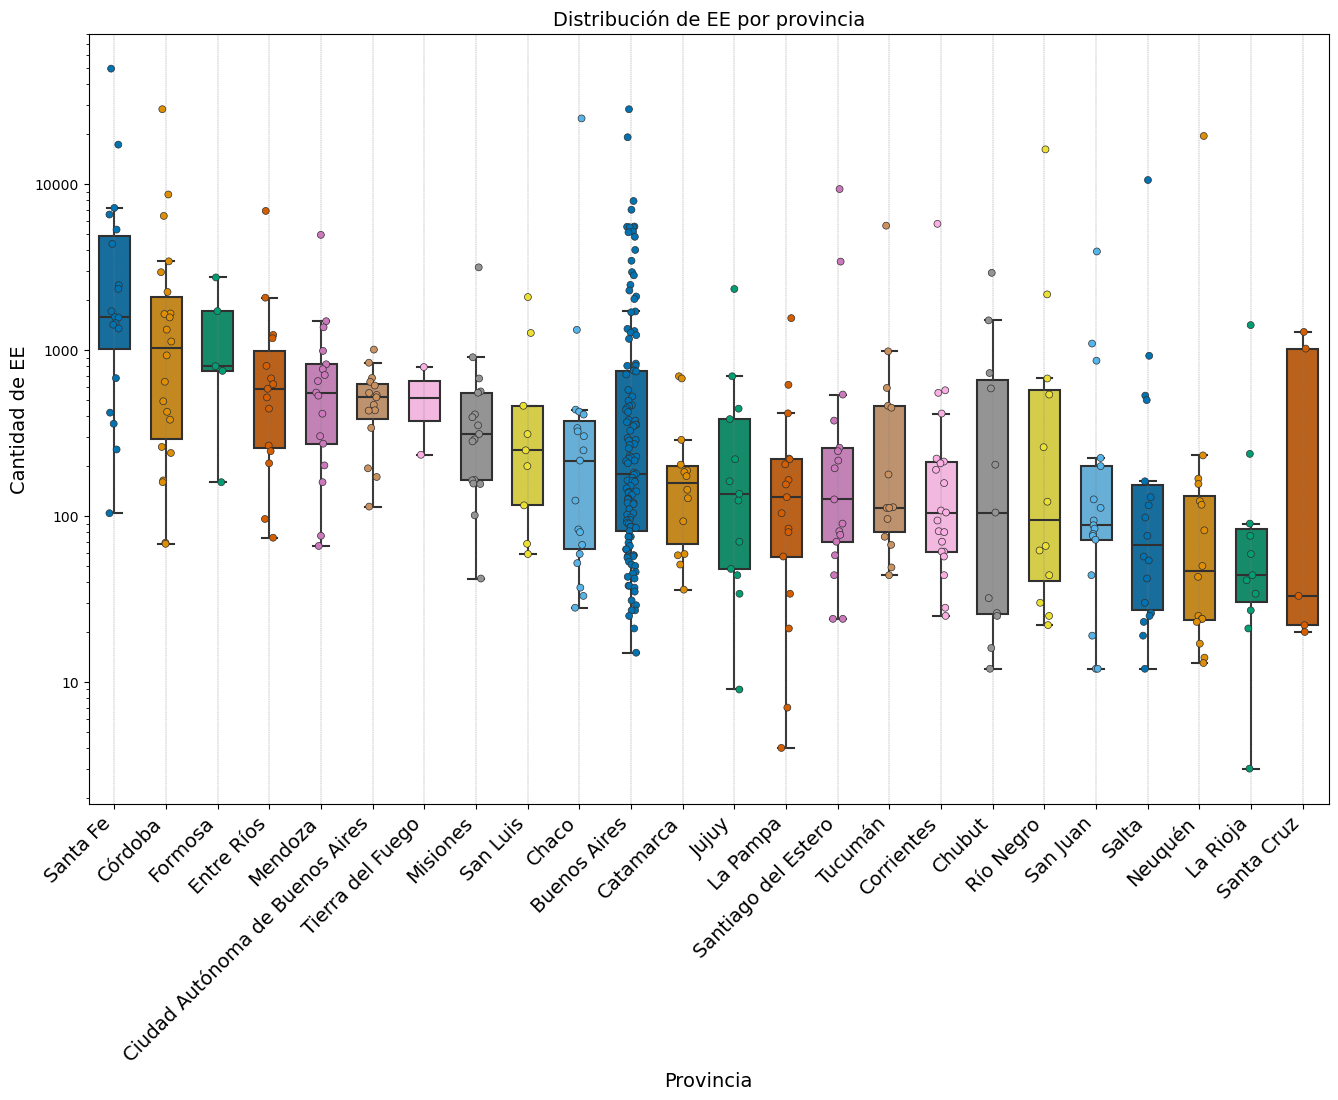

In [2]:
con = duckdb.connect()

con.register('EE_limpio01', EE_limpio01)
con.register('BP_limpio', BP_limpio) 
gr = pd.read_csv(r"Graficos\\graf_3.csv") 

query = """
    SELECT Departamento, provincia, COUNT(Departamento) AS cantidad 
    FROM EE_limpio01 JOIN BP_limpio ON EE_limpio01."id_departamento" = BP_limpio."id_departamento"
    GROUP BY Departamento, provincia
    ORDER BY cantidad DESC
"""

resultado = con.execute(query).fetchdf()
resultado.to_csv('graf_3.csv', index=False)

#ordena por mediana de provincia, de manera descendiente
provincia_orden = (
    gr.groupby("provincia")["cantidad"]
    .median()
    .sort_values(ascending=False)
    .index
)

#tamaño del grafico
plt.figure(figsize=(16,10))

# --- Boxplot ---
boxplot = sns.boxplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,
    palette="colorblind",
    width=0.6,
    showfliers=False,  # Ocultamos outliers (los mostramos con stripplot)
    linewidth=1.5
)

# --- Boxplot ---
sns.stripplot(
    data=gr,
    x="provincia",
    y="cantidad",
    order=provincia_orden,    # Agrupar por provincia
    palette="colorblind",     # Misma paleta que boxplot
    dodge=False,           
    alpha=1,
    size=5,
    linewidth=0.5,
    legend=False           # Oculta leyenda duplicada
)

# para la escala del eje y
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')


# --- Ajustes finales ---
plt.title("Distribución de EE por provincia", fontsize=14)
plt.xlabel("Provincia", fontsize=14)
plt.ylabel("Cantidad de EE", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=14)

#lineas para que se entiende a que provincia pertenece cada boxplot
for i in range(len(provincia_orden)):
    plt.axvline(i, color='gray', linewidth=0.3, linestyle='--')
    
plt.show()
